In [1]:
import numpy as np
from numpy import polyfit
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares
from scipy.stats import linregress
from math import floor
from pathlib import Path
import json
from matplotlib.backends.backend_pdf import PdfPages

import warnings
warnings.filterwarnings("error")


_plot_params = 0
def plot_init( numrows, numcols, axis = True ):
    plt.figure( figsize = ( numcols * 6, numrows * 4  ) )
    global _plot_params
    _plot_params = [ numrows, numcols, 0 ]
    if( axis ):
        plot_next()
def plot_next():
    _plot_params[2] += 1
    plt.subplot( *_plot_params )

In [2]:
# Data saving path
savepath = "A04_results_percolation"

In [10]:
# Load data

def load( filename ):
    text = filename.read_text()
    text = text.replace("nan","0")
    text = text.replace("False", "false" )
    text = text.replace("True", "true" )
    text = text.replace(",]", "]" )
    return json.loads( text )

data = []

# Load the big stuff
p = Path('../AsusAnalysis/20220312Percolationscan_20220312/')
dirs = [f for f in p.iterdir() if f.is_dir()]


for d in dirs:
    item = {}
    item.update( load( d / 'details.txt'     ) )
    item.update( load( d / 'deposition.txt'  ) )
    item.update( load( d / 'percolation.txt' ) )
    data.append(item)

# Load smaller stuff
p = Path('../AsusAnalysis/20220313Percolationscan_20220321/')
dirs = [f for f in p.iterdir() if f.is_dir()]

for d in dirs:
    item = {}
    item.update( load( d / 'details.txt'     ) )
    item.update( load( d / 'deposition.txt'  ) )
    item.update( load( d / 'percolation.txt' ) )
    data.append(item)

In [11]:
# useful data
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

polys = np.unique(  [i['dep_polymers'] for i in data] )
sides =  np.unique( [i['side'] for i in data] )
qs =  np.unique( [i['defects_frac'] for i in data] )
gammas =  np.unique( [i['gamma'] for i in data] )
print( sides )
print( qs )
print( gammas )
print( polys )

assert( sides.size * qs.size * gammas.size * polys.size == len(data) )

[  64  128  256  512 1024]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.4 0.8 1.2 1.6]
['Dimers' 'Linear trimers' 'Squared' 'Trimers']


### Delta

$ \Delta \coloneqq \sqrt{ <{ p_j^2 }> - <{ p_j }^2> } $

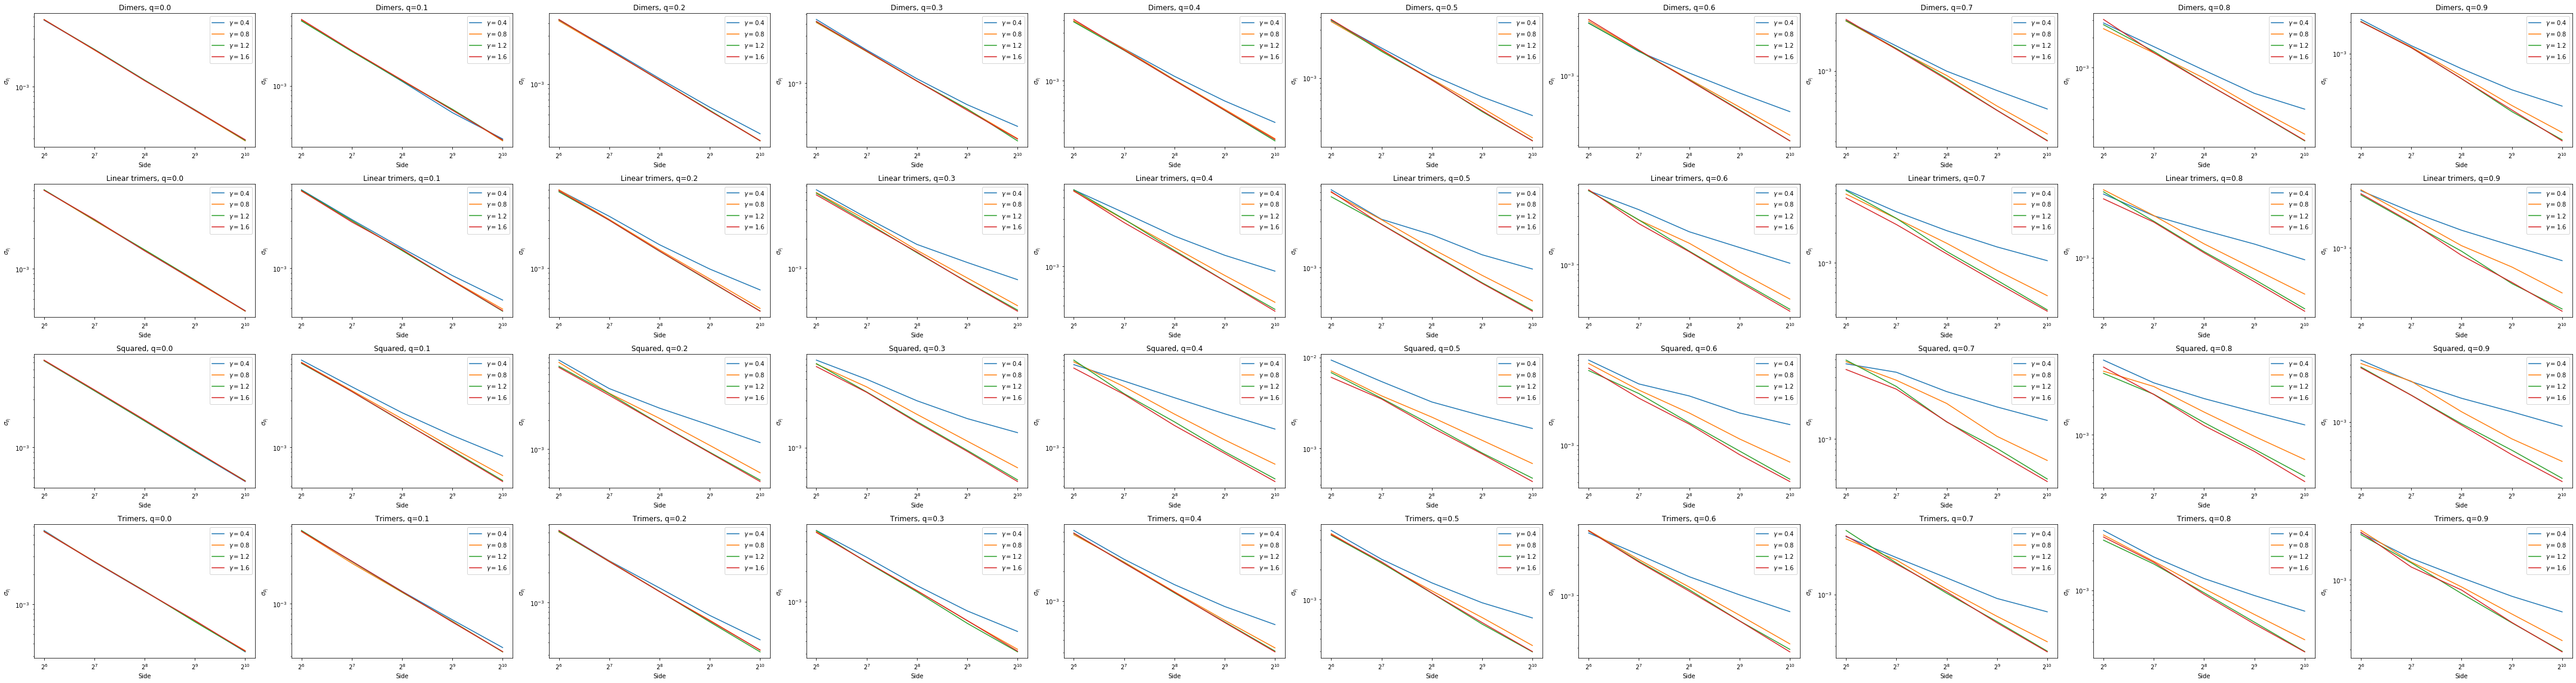

In [20]:
# Jamming density standard deviation as function of L for different values of gamma in different q and different shapes

qsc = qs[ qs < 1 ]

fig = plot_init( len( polys ), len( qsc ), False )

ylims_1 = [ 0, 1 ]
ylims_2 = [ 0, 1 ]

for i_p, p in enumerate( polys ):
    for i_q, q in enumerate( qsc ):
        axes = plot_next()
        for i_gamma, gamma in enumerate( gammas ):
            x = np.array([ v['side']                    for v in data if v['dep_polymers'] == p and  v['defects_frac'] == q and  v['gamma'] == gamma ])
            y = np.array([ v['occupation_fraction_std'] for v in data if v['dep_polymers'] == p and  v['defects_frac'] == q and  v['gamma'] == gamma ])
            sort_idx = np.argsort( x )
            plt.loglog( x[sort_idx], y[sort_idx], color=color_list[ i_gamma ], label= r'$\gamma=$' + str(gamma), basex = 2, basey = 10 )

        plt.title( p + ", q=" + str(q) )
        plt.legend()
        plt.xlabel(r'Side')
        plt.ylabel(r'$\sigma_{p_j}$')
        plt.xticks( sides )

plt.tight_layout()

plt.savefig( savepath + "/Delta.pdf")

Assume $\Delta(L) = AL^{-1/\nu} + B $

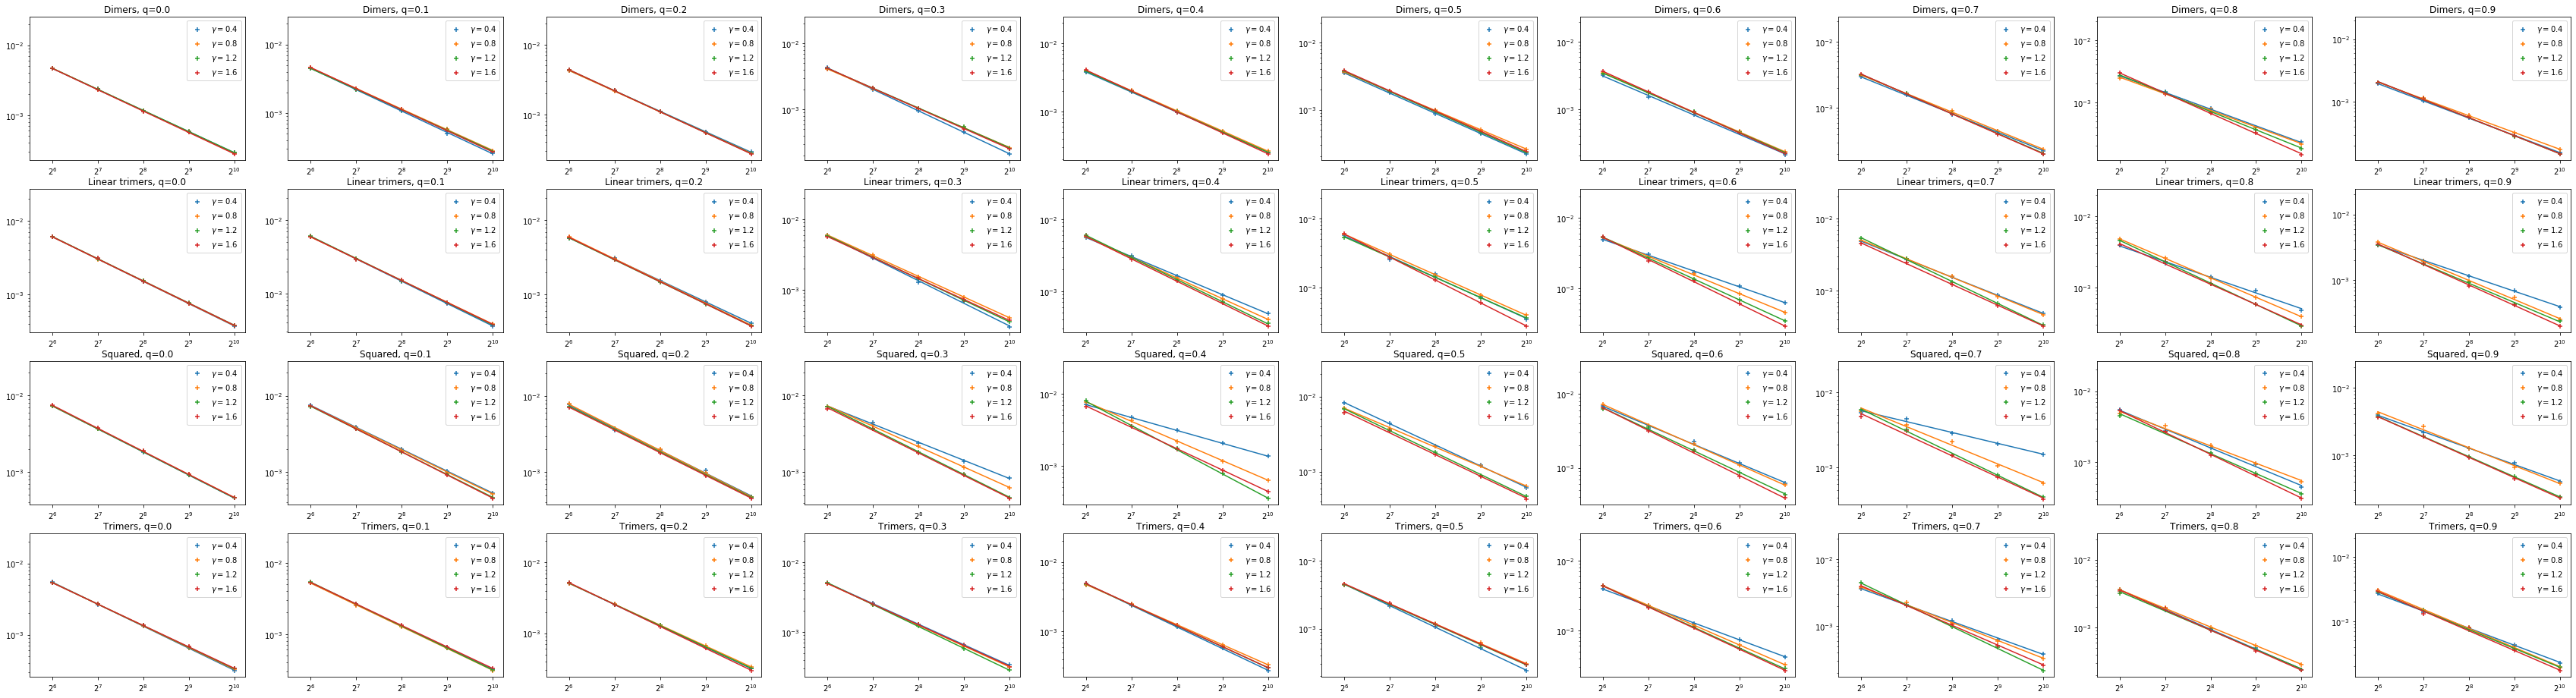

In [21]:
# Fits

fig = plot_init( len( polys ), len( qsc ), False )

ylims_1 = [ 0, 1 ]
ylims_2 = [ 0, 1 ]

fit_results = []

for i_p, p in enumerate( polys ):
    for i_q, q in enumerate( qsc ):
        axes = plot_next()
        for i_gamma, gamma in enumerate( gammas ):
            x = np.array([ v['side']                    for v in data if v['dep_polymers'] == p and  v['defects_frac'] == q and  v['gamma'] == gamma ])
            y = np.array([ v['occupation_fraction_std'] for v in data if v['dep_polymers'] == p and  v['defects_frac'] == q and  v['gamma'] == gamma ])
            
            sort_idx = np.argsort( x )
            x = x[sort_idx]
            y = y[sort_idx]
            lx= np.log2( x )

            ## Iterative fit
            ### Initial values
            [menounosunu, log2A], covmat = polyfit( lx, np.log2(y), 1, cov = True )
            B = 0
            count = 0

            while( True ):
                prevmenounosunu = menounosunu

                ### Fit of B
                B = np.mean( y - np.power( 2, menounosunu * lx + log2A ) )
                B = max( min( B, min( y ) - 1e-15  ), 0 ) # ensure is valuable
                errB = np.std( y - np.power( 2, menounosunu * lx + log2A ) )

                ### Fit for A and menounosunu
                [menounosunu, log2A], covmat = polyfit( np.log2(x), np.log2(y - B), 1, cov = True )

                ### Check for exit condition
                excond = abs( prevmenounosunu - menounosunu ) / min( abs( menounosunu ), abs( prevmenounosunu ) )

                if( excond < 1e-7 ):
                    break

                count += 1

            errmenounosonu = max( np.sqrt( covmat[0,0] ), abs( prevmenounosunu - menounosunu ) )

            fit_results.append({
                'gamma': gamma, 'q': q, 'p': p,
                'A': ( 2 ** log2A ), 'unosunu': -menounosunu, 'nu': -1/menounosunu, 'B': B,
                'errA': np.sqrt( covmat[1,1] ) * ( 2 ** log2A ), 'errunosunu': errmenounosonu, 'errnu': errmenounosonu / menounosunu**2, 'errB': errB
            })
            

            # plt.scatter( np.log( x ), np.log( y ) - pars[0] + pars[1] * np.log( x ) )
            plt.scatter( x, y - B, color=color_list[ i_gamma ], label= r'$\gamma=$' + str(gamma), marker='+' )
            plt.plot( x, ( 2 ** log2A ) * ( x ** menounosunu ) )

        plt.xscale( 'log', basex = 2 )
        plt.yscale( 'log', basey = 10 )

        plt.title( p + ", q=" + str(q) )
        plt.legend()
        # plt.xlabel(r'Side')
        # plt.ylabel(r'$\sigma_{p_j}$')
        # plt.xticks( sides )

plt.savefig( 'CriticalExpoF' )
plt.savefig( savepath + "/DeltaFit.pdf")

# plt.tight_layout()
# plt.show()

Exception ignored in: <_io.FileIO name='A04_results_percolation/DeltaFitPars.pdf' mode='wb' closefd=True>


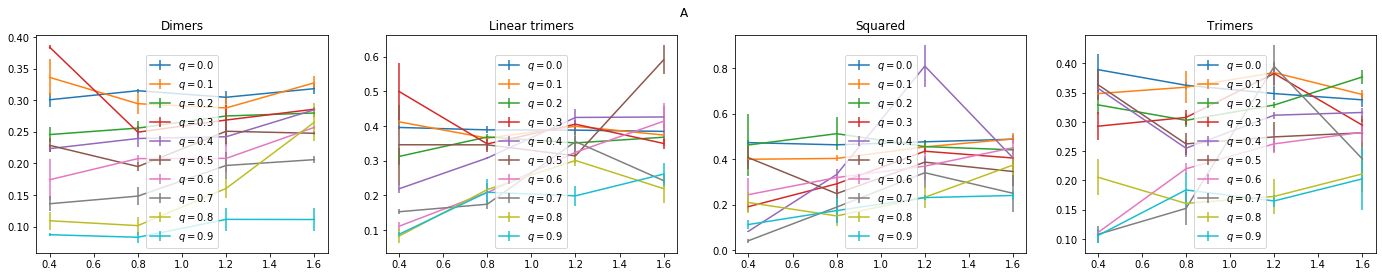

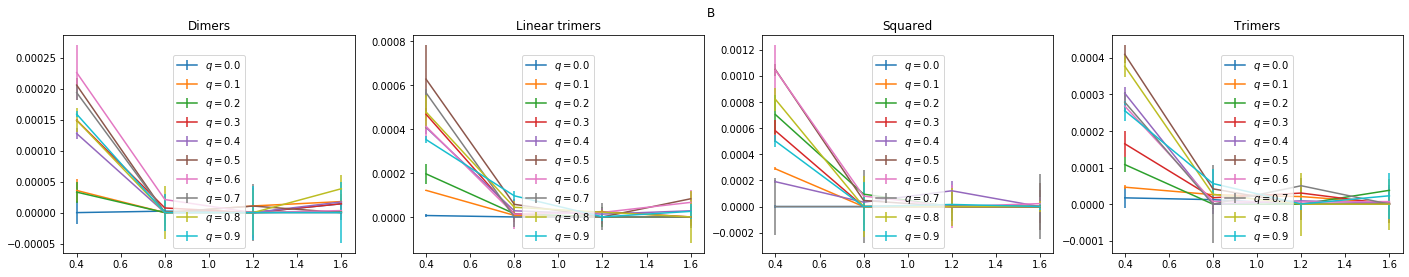

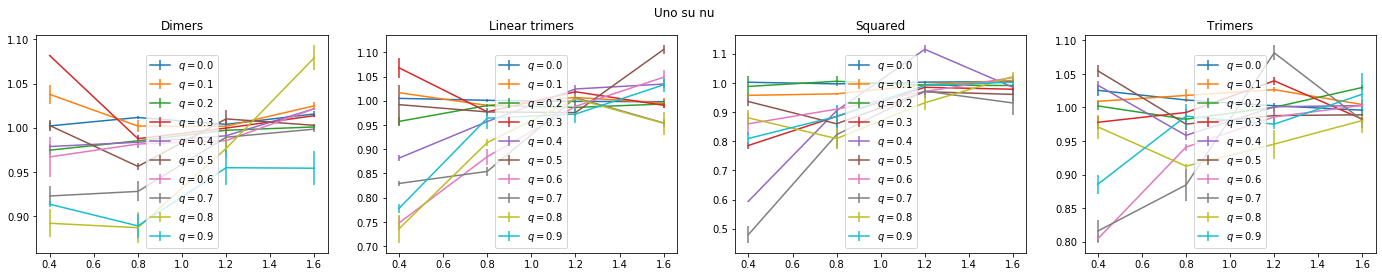

In [23]:
pdf = PdfPages( savepath + "/DeltaFitPars.pdf" )
fig = plot_init( 1, len( polys ), False )

for i_p, p in enumerate( polys ):
    axes = plot_next( )
    for i_q, q in enumerate( qsc ):
        x = np.array([ v['gamma']   for v in fit_results if v['p'] == p and  v['q'] == q ])
        y = np.array([ v['A'] for v in fit_results if v['p'] == p and  v['q'] == q ])
        erry = np.array([ v['errA'] for v in fit_results if v['p'] == p and  v['q'] == q ])

        sort_idx = np.argsort( x )
        plt.errorbar( x[sort_idx], y[sort_idx], erry[sort_idx], color=color_list[ i_q ], label= r'$q=$' + str(q) )
    
    plt.title( p )
    plt.legend()
    plt.suptitle( 'A')

pdf.savefig()
plt.show()

fig = plot_init( 1, len( polys ), False )
for i_p, p in enumerate( polys ):
    axes = plot_next( )
    for i_q, q in enumerate( qsc ):
        x   = np.array([ v['gamma']   for v in fit_results if v['p'] == p and  v['q'] == q ])
        y   = np.array([ v['B'] for v in fit_results if v['p'] == p and  v['q'] == q ])
        erry= np.array([ v['errB'] for v in fit_results if v['p'] == p and  v['q'] == q ])

        sort_idx = np.argsort( x )
        plt.errorbar( x[sort_idx], y[sort_idx], erry[sort_idx], color=color_list[ i_q ], label= r'$q=$' + str(q) )
    
    plt.title( p )
    plt.legend()
    plt.suptitle( 'B')

pdf.savefig()
plt.show()

fig = plot_init( 1, len( polys ), False )
for i_p, p in enumerate( polys ):
    axes = plot_next( )
    for i_q, q in enumerate( qsc ):
        x   = np.array([ v['gamma']   for v in fit_results if v['p'] == p and  v['q'] == q ])
        y   = np.array([ v['unosunu'] for v in fit_results if v['p'] == p and  v['q'] == q ])
        erry= np.array([ v['errunosunu'] for v in fit_results if v['p'] == p and  v['q'] == q ])

        sort_idx = np.argsort( x )
        plt.errorbar( x[sort_idx], y[sort_idx], erry[sort_idx], color=color_list[ i_q ], label= r'$q=$' + str(q) )
    
    plt.title( p )
    plt.legend()
    plt.suptitle( 'Uno su nu')

pdf.savefig()
plt.show()

pdf.close()

##  Percolation studies

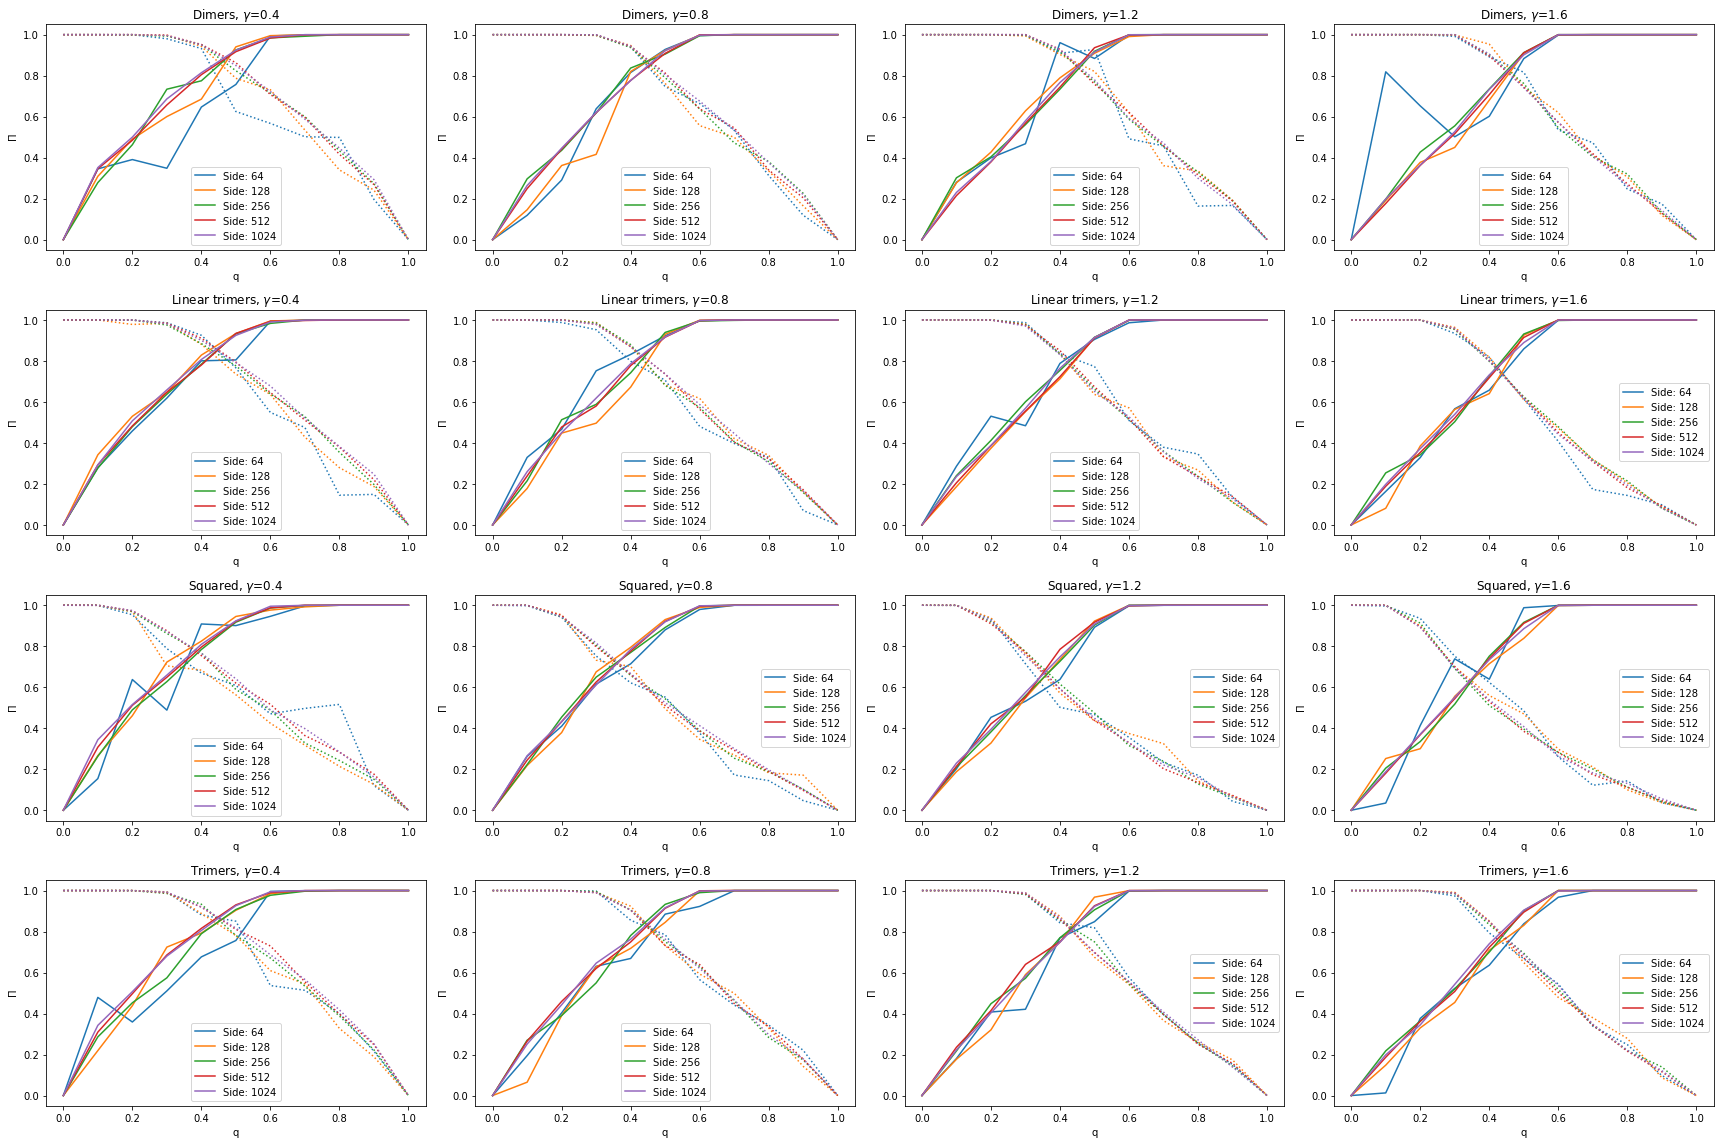

In [12]:
# Percolation probability as function of q for different values of L in different gamma and different shapes

fig = plot_init( len( polys ), len( gammas ), False )

for i_p, p in enumerate( polys ):
    for i_gamma, gamma in enumerate( gammas ):
        axes = plot_next()
        for i_side, side in enumerate( sides ):
            x = np.array([ v['defects_frac'] for v in data if v['dep_polymers'] == p and  v['gamma'] == gamma and  v['side'] == side ])
            y1= np.array([ v['defperc_avg']  for v in data if v['dep_polymers'] == p and  v['gamma'] == gamma and  v['side'] == side ])
            y2= np.array([ v['atmperc_avg']  for v in data if v['dep_polymers'] == p and  v['gamma'] == gamma and  v['side'] == side ])

            sort_idx = np.argsort( x )
            plt.plot( x[sort_idx], y1[sort_idx], '-', color=color_list[ i_side ], label= f"Side: {side}" )
            plt.plot( x[sort_idx], y2[sort_idx], ':', color=color_list[ i_side ] )
        plt.title( p + r", $\gamma$=" + str(gamma) )
        plt.legend()
        plt.xlabel(r'q')
        plt.ylabel(r'$\Pi$')

plt.tight_layout()